<CENTER>
</br>
<p><font size="5">  M2MO & EY - Internship </font></p>
<p><font size="5">  Modelling Forward Initial Margin and Counterparty Risk in Uncleared Derivatives </font></p>
<p><font size="4">  SANGLIER Nathan </font></p>
<p><font size="3"></br>September 2025</font></br></div>
<p><span style="color:blue">nathan.sanglier@fr.ey.com</span>
</p>
</CENTER>

In this notebook, we analyze in details the JLSMC method. More precisely, we investigate the different steps of this methods; the regression of conditional raw moments, the fitting of Johnson distribution parameters, and finally the minimzation procedure to find the value-at-risk function. One case chose the put BS case stusy or the swaption HW1F one by modifying the corresponding risk factors and portfolio. Moreover, notice that the analysis is done here at a specific time $t = t_{\text{ref}}$ and some statistical verifications are additionally done at a specific risk factors value $X_{\text{ref}}$.

## <span id="section-0" style="color:#00B8DE"> 0 - Imports, Parameters </span>

In [1]:
import  warnings
import  backend.as99
import  phitter
import  numpy                           as     np
import  matplotlib.pyplot               as     plt
from    backend.utils                   import  TimeGrid, get_mtmdiff_nmc, get_centred_moms, get_skewkurt, get_mtmdiff, moment_matching_johnson, get_quantile_normal, get_pdf_normal, get_quantile_johnson, get_pdf_johnson
from    backend.regressors              import  RawMomentsRegressor, JohnsonSupportRegressor
from    backend.pricing_models          import  BlackScholes, YieldCurve, OneFactorHullWhite
from    backend.pricing_engines         import  PutBlackScholes, SwaptionOneFactorHullWhite
from    backend.forward_im_models       import  JohnsonLeastSquaresMonteCarlo
from    statsmodels.stats.diagnostic    import  normal_ad
from    scipy.stats                     import  norm, johnsonsu, johnsonsb, lognorm, kstest
from    math                            import  exp

In [2]:
np.random.seed(0)
plt.style.use('ggplot')
color_jlsmc     = 'blue'
color_glsmc     = 'red'
color_invalid   = 'purple'
jtypes_map      = {'SL': 1, 'SU': 2, 'SB': 3, 'SN': 4, 'ST': 5}
rev_jtypes_map  = {v: k for k, v in jtypes_map.items()}

num_paths   = 10000
maturity    = 1
time_grid   = TimeGrid(1/240, maturity)
alpha       = 0.99
mpor        = 1/24

## <span id="section-0" style="color:#00B8DE"> I - Generating risk factors and portfolio price paths of interest </span>

Let us first define our risk factors and portfolio, and compute the associated paths. Uncomment/comment the first/second block to use either case study.

In [3]:

spot = 100
risk_factor = BlackScholes(0.3, 0.05, spot)
portfolio   = PutBlackScholes(95, maturity, risk_factor)
'''
yield_curve = YieldCurve(0.05, -0.03, -0.18)
spot = yield_curve.zero_coupon_yield(0)
risk_factor = OneFactorHullWhite(0.01, 0.015, yield_curve)
portfolio   = SwaptionOneFactorHullWhite(maturity, 0.04, TimeGrid(0.25, 4.75), 10000, risk_factor)
'''

risk_factor.set_time_grid(time_grid)
risk_factor_paths   = risk_factor.generate_paths(num_paths)
mtm_paths           = portfolio.generate_paths(risk_factor_paths)
mtmdiff_paths       = get_mtmdiff(mtm_paths, mpor, time_grid)

Now, we freeze the method used for moment matching (ie. conditional raw moment regression) in the JLSMC and GLSMC methods, as well as how are calculated the support values. You can change (and you should if you want to see the impact of each method!) all of these settings except the GLSMC one, since it is the setting taken in the original paper and is considered as a benchmark.

In [4]:
moment_matching_setting_jlsmc   = {'method': 'LR', 'ridge': 0, 'basis_type': 'laguerre', 'order': 2, 'regress_mean': True}
moment_matching_setting_glsmc   = {'method': 'LR', 'ridge': 0, 'basis_type': 'canonical', 'order': 2, 'regress_mean': False}
support_values_setting          = {'initial nb': 100, 'perc add tails': 0.1, 'add ends': False}
q_all = JohnsonLeastSquaresMonteCarlo(alpha, mpor, time_grid, None, support_values_setting, None).get_percent_values()

Next, we compute all the risk factors values and portfolio prices that will be used in the analysis at $t_\text{ref}$.

In [5]:
tref        = 1/12 # reference time for analyzing the JLSMC method
ind_tref    = time_grid.find_index(tref)
risk_factor_train   = risk_factor_paths[:, ind_tref]
mtm_train           = mtm_paths[:, ind_tref]
mtm_func            = np.linspace(np.min(mtm_train), np.max(mtm_train), 1000) # for plotting moments reg, moments matching, value-at-risk function
mtm_supp            = np.quantile(mtm_train, q_all, method='inverted_cdf') # support values

risk_factor_ref = spot # reference value of risk factor for statistical analysis in last part
risk_factor.set_time_grid(TimeGrid(time_grid.timestep, 0, tref))
mtm_ref = portfolio.generate_paths(np.array([[risk_factor_ref]]))[0] # associated mtm value
risk_factor.set_time_grid(time_grid)

num_paths_test          = 100
num_nested_paths_test   = 100000
risk_factor_test        = np.linspace(np.min(risk_factor_train), np.max(risk_factor_train), num_paths_test) # for plotting nested MC results
risk_factor.set_time_grid(TimeGrid(time_grid.timestep, 0, tref))
mtm_test = portfolio.generate_paths(risk_factor_test.reshape(-1, 1)).reshape(-1) # associated mtm values
risk_factor.set_time_grid(time_grid)

mtmdiff_nmc_test    = get_mtmdiff_nmc(num_nested_paths_test, portfolio, risk_factor_test, mtm_test, mpor, tref)
muraw_test          = np.column_stack([np.mean(mtmdiff_nmc_test**i, axis=1) for i in range(1, 5)]) # "true" raw moments computed via nested MC
mu_test                         = get_centred_moms(muraw_test)[0] # "true" centred moments
skew_test, kurt_test, _, _, _   = get_skewkurt(mu_test) # "true" skewness and kurtosis

num_nested_paths_ref            = 100000
mtmdiff_nmc_ref                 = get_mtmdiff_nmc(num_nested_paths_ref, portfolio, np.array([risk_factor_ref]), mtm_ref, mpor, tref) # to get true distribution metrics for statistical analysis in last part
mtmdiff_nmc_ref_bis             = get_mtmdiff_nmc(num_nested_paths_ref, portfolio, np.array([risk_factor_ref]), mtm_ref, mpor, tref) # for statistical test
muraw_ref                       = np.column_stack([np.mean(mtmdiff_nmc_ref**i, axis=1) for i in range(1, 5)])
mu_ref                          = get_centred_moms(muraw_ref)[0]
skew_ref, kurt_ref, _, _, _     = get_skewkurt(mu_ref)
quant_ref                       = np.quantile(mtmdiff_nmc_ref[0, :], alpha, method='inverted_cdf') # true value-at-risk for last part

num_paths_comp                  = 1000
num_nested_paths_comp           = 100000
bin_size                        = num_paths//num_paths_comp
sorted_inds                     = np.argsort(mtm_train)
selec_inds                      = np.array([sorted_inds[i*bin_size + bin_size//2] for i in range(num_paths_comp)]) # "resampling" since we can't afford to do nested MC on all training points
risk_factor_comp                = risk_factor_paths[selec_inds, ind_tref] # used to calculate MSE wrt. nested MC results for value-at-risk function estimation
risk_factor.set_time_grid(TimeGrid(time_grid.timestep, 0, tref))
mtm_comp = portfolio.generate_paths(risk_factor_comp.reshape(-1, 1))
risk_factor.set_time_grid(time_grid)
mtmdiff_nmc_comp                = get_mtmdiff_nmc(num_nested_paths_comp, portfolio, risk_factor_comp, mtm_comp, mpor, tref)
muraw_comp                      = np.column_stack([np.mean(mtmdiff_nmc_comp**i, axis=1) for i in range(1, 5)])
mu_comp                         = get_centred_moms(muraw_comp)[0]
skew_comp, kurt_comp, _, _, _   = get_skewkurt(mu_comp)
quant_comp                      = np.quantile(mtmdiff_nmc_comp, alpha, method='inverted_cdf', axis=1)

Let us plot the support values.

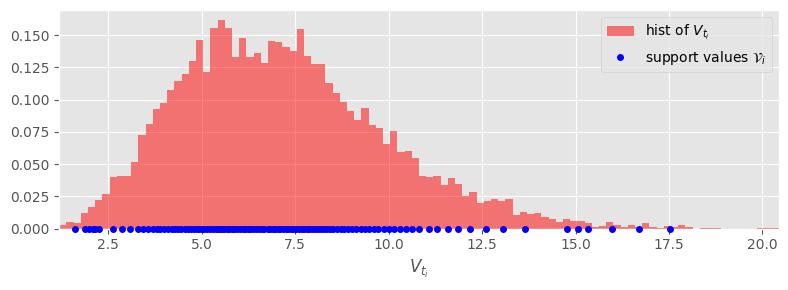

In [6]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.hist(mtm_train, bins=100, density=True, alpha=0.5, color='red', label='hist of $V_{t_i}$')
ax.plot(mtm_supp, np.zeros_like(mtm_supp), 'o', color=color_jlsmc, label='support values $\mathcal{V}_i$', clip_on=False, zorder=10, markersize=4)
ax.set_xlabel('$V_{t_i}$')
ax.set_xlim(np.min(mtm_train), np.max(mtm_train))
ax.legend()
plt.tight_layout()
plt.show()

## <span id="section-2" style="color:#00B8DE"> II - Moments Regression </span>

The first step is a regression to estimate the conditional raw moments functions, and deduce the conditional variance, skewness, kurtosis at the values $v$ of interest.

In [7]:
y_train_jlsmc = mtmdiff_paths[:, ind_tref:ind_tref+1]**np.arange(1, 5)
moments_regressor_jlsmc = RawMomentsRegressor(moment_matching_setting_jlsmc, 4)
moments_regressor_jlsmc.fit(mtm_train, y_train_jlsmc)
murawhat_test_jlsmc    = moments_regressor_jlsmc.predict(mtm_test)
murawhat_func_jlsmc    = moments_regressor_jlsmc.predict(mtm_func)
murawhat_supp_jlsmc    = moments_regressor_jlsmc.predict(mtm_supp)
murawhat_ref_jlsmc     = moments_regressor_jlsmc.predict(mtm_ref)
murawhat_train_jlsmc   = moments_regressor_jlsmc.predict(mtm_train)
muhat_test_jlsmc, maskhat_test_jlsmc    = get_centred_moms(murawhat_test_jlsmc)
muhat_func_jlsmc, maskhat_func_jlsmc    = get_centred_moms(murawhat_func_jlsmc)
muhat_supp_jlsmc, maskhat_supp_jlsmc    = get_centred_moms(murawhat_supp_jlsmc)
muhat_ref_jlsmc, maskhat_ref_jlsmc      = get_centred_moms(murawhat_ref_jlsmc)
muhat_train_jlsmc, maskhat_train_jlsmc  = get_centred_moms(murawhat_train_jlsmc)
skewhat_test_jlsmc, kurthat_test_jlsmc, mask_skewhat_test_jlsmc, mask_kurthat_test_jlsmc, mask_tothat_test_jlsmc        = get_skewkurt(muhat_test_jlsmc, maskhat_test_jlsmc)
skewhat_func_jlsmc, kurthat_func_jlsmc, mask_skewhat_func_jlsmc, mask_kurthat_func_jlsmc, mask_tothat_func_jlsmc        = get_skewkurt(muhat_func_jlsmc, maskhat_func_jlsmc)
skewhat_supp_jlsmc, kurthat_supp_jlsmc, mask_skewhat_supp_jlsmc, mask_kurthat_supp_jlsmc, mask_tothat_supp_jlsmc        = get_skewkurt(muhat_supp_jlsmc, maskhat_supp_jlsmc)
skewhat_ref_jlsmc, kurthat_ref_jlsmc, mask_skewhat_ref_jlsmc, mask_kurthat_ref_jlsmc, mask_tothat_ref_jlsmc             = get_skewkurt(muhat_ref_jlsmc, maskhat_ref_jlsmc)
skewhat_train_jlsmc, kurthat_train_jlsmc, mask_skewhat_train_jlsmc, mask_kurthat_train_jlsmc, mask_tothat_train_jlsmc   = get_skewkurt(muhat_train_jlsmc, maskhat_train_jlsmc)


y_train_glsmc           = mtmdiff_paths[:, ind_tref:ind_tref+1]**np.arange(1, 3)
moments_regressor_glsmc = RawMomentsRegressor(moment_matching_setting_glsmc, 2)
moments_regressor_glsmc.fit(mtm_train, y_train_glsmc)
murawhat_test_glsmc     = moments_regressor_glsmc.predict(mtm_test)
murawhat_func_glsmc     = moments_regressor_glsmc.predict(mtm_func)
murawhat_supp_glsmc     = moments_regressor_glsmc.predict(mtm_supp)
murawhat_ref_glsmc      = moments_regressor_glsmc.predict(mtm_ref)
murawhat_comp_glsmc     = moments_regressor_glsmc.predict(mtm_comp)
murawhat_train_glsmc    = moments_regressor_glsmc.predict(mtm_train)
murawhat_test_glsmc     = np.column_stack([murawhat_test_glsmc, np.zeros_like(murawhat_test_glsmc[:, 1]), 3*murawhat_test_glsmc[:, 1]**2])
murawhat_func_glsmc     = np.column_stack([murawhat_func_glsmc, np.zeros_like(murawhat_func_glsmc[:, 1]), 3*murawhat_func_glsmc[:, 1]**2])
murawhat_ref_glsmc      = np.column_stack([murawhat_ref_glsmc, np.zeros_like(murawhat_ref_glsmc[:, 1]), 3*murawhat_ref_glsmc[:, 1]**2])
murawhat_comp_glsmc     = np.column_stack([murawhat_comp_glsmc, np.zeros_like(murawhat_comp_glsmc[:, 1]), 3*murawhat_comp_glsmc[:, 1]**2, ])
murawhat_train_glsmc    = np.column_stack([murawhat_train_glsmc, np.zeros_like(murawhat_train_glsmc[:, 1]), 3*murawhat_train_glsmc[:, 1]**2])
muhat_test_glsmc, maskhat_test_glsmc    = get_centred_moms(murawhat_test_glsmc)
muhat_func_glsmc, maskhat_func_glsmc    = get_centred_moms(murawhat_func_glsmc)
muhat_ref_glsmc, maskhat_ref_glsmc      = get_centred_moms(murawhat_ref_glsmc)
muhat_comp_glsmc, maskhat_comp_glsmc    = get_centred_moms(murawhat_comp_glsmc)
muhat_train_glsmc, maskhat_train_glsmc  = get_centred_moms(murawhat_train_glsmc)
skewhat_test_glsmc, kurthat_test_glsmc, mask_skewhat_test_glsmc, mask_kurthat_test_glsmc, mask_tothat_test_glsmc        = get_skewkurt(muhat_test_glsmc, maskhat_test_glsmc)
skewhat_func_glsmc, kurthat_func_glsmc, mask_skewhat_func_glsmc, mask_kurthat_func_glsmc, mask_tothat_func_glsmc        = get_skewkurt(muhat_func_glsmc, maskhat_func_glsmc)
skewhat_ref_glsmc, kurthat_ref_glsmc, mask_skewhat_ref_glsmc, mask_kurthat_ref_glsmc, mask_tothat_ref_glsmc             = get_skewkurt(muhat_ref_glsmc, maskhat_ref_glsmc)
skewhat_comp_glsmc, kurthat_comp_glsmc, mask_skewhat_comp_glsmc, mask_kurthat_comp_glsmc, mask_tothat_comp_glsmc        = get_skewkurt(muhat_comp_glsmc, maskhat_comp_glsmc)
skewhat_train_glsmc, kurthat_train_glsmc, mask_skewhat_train_glsmc, mask_kurthat_train_glsmc, mask_tothat_train_glsmc   = get_skewkurt(muhat_train_glsmc, maskhat_train_glsmc)

Let us plot the conditional raw moments estimated for the moments regression settings of both JLSMC and GLSMC methods.

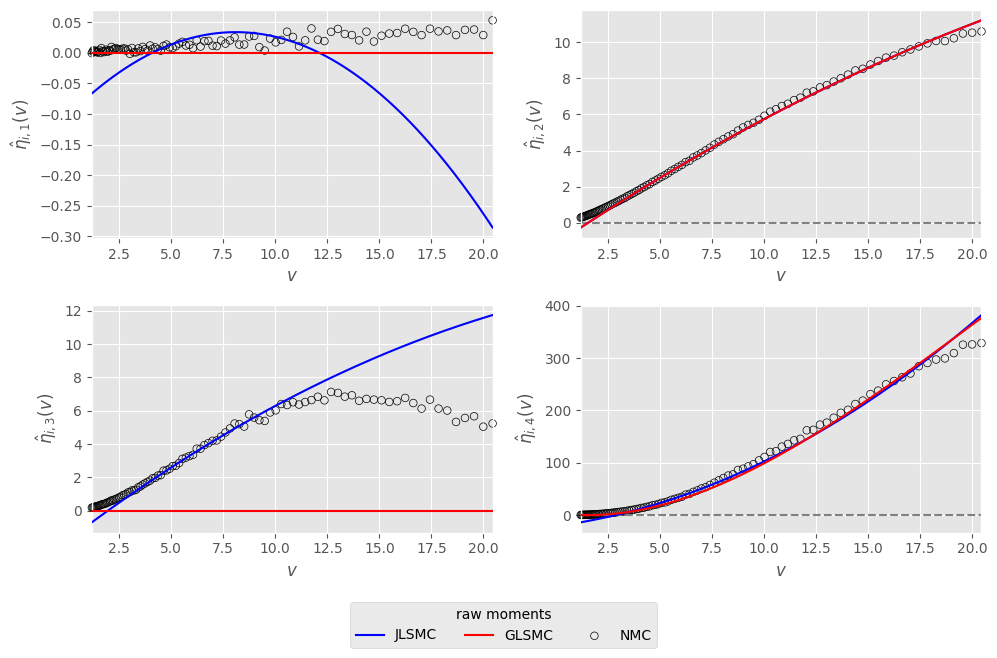

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

axs[0, 0].plot(mtm_func, murawhat_func_jlsmc[:, 0], color=color_jlsmc, label='JLSMC', zorder=3)
axs[0, 0].plot(mtm_func, murawhat_func_glsmc[:, 0], color=color_glsmc, label='GLSMC', zorder=3)
axs[0, 0].scatter(mtm_test, muraw_test[:, 0], color='black', s=30, facecolors='none', label='NMC', clip_on=False, zorder=2)
axs[0, 0].set_xlabel('$v$')
axs[0, 0].set_ylabel('$\\hat \\eta_{i, 1}(v)$')
axs[0, 0].set_xlim(np.min(mtm_func), np.max(mtm_func))

axs[0, 1].plot(mtm_func, murawhat_func_jlsmc[:, 1], color=color_jlsmc, zorder=3)
axs[0, 1].plot(mtm_func, murawhat_func_glsmc[:, 1], color=color_glsmc, zorder=3)
axs[0, 1].scatter(mtm_test, muraw_test[:, 1], color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[0, 1].axhline(0, color='grey', linestyle='--')
axs[0, 1].set_xlabel('$v$')
axs[0, 1].set_ylabel('$\\hat \\eta_{i, 2}(v)$')
axs[0, 1].set_xlim(np.min(mtm_func), np.max(mtm_func))

axs[1, 0].plot(mtm_func,  murawhat_func_jlsmc[:, 2], color=color_jlsmc, zorder=3)
axs[1, 0].plot(mtm_func, murawhat_func_glsmc[:, 2], color=color_glsmc, zorder=3)
axs[1, 0].scatter(mtm_test, muraw_test[:, 2], color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[1, 0].set_xlabel('$v$')
axs[1, 0].set_ylabel('$\\hat \\eta_{i, 3}(v)$')
axs[1, 0].set_xlim(np.min(mtm_func), np.max(mtm_func))

axs[1, 1].plot(mtm_func, murawhat_func_jlsmc[:, 3], color=color_jlsmc, zorder=3)
axs[1, 1].plot(mtm_func, murawhat_func_glsmc[:, 3], color=color_glsmc, zorder=3)
axs[1, 1].scatter(mtm_test, muraw_test[:, 3], color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[1, 1].axhline(0, color='grey', linestyle='--')
axs[1, 1].set_xlabel('$v$')
axs[1, 1].set_ylabel('$\\hat \\eta_{i, 4}(v)$')
axs[1, 1].set_xlim(np.min(mtm_func), np.max(mtm_func))

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.1), title='raw moments')

plt.tight_layout()
plt.show()

Let us now plot all the metrics of interest for Johnson moment matching. Notice that we have invalid support values corresponding to support values for which metrics values are outside their domain definition. Hence, these invalid support values should be removed from further computations. The support quantiles associated to invalid support values are set to zero only to visualize them on the graphs.

Number of invalid support points: 7


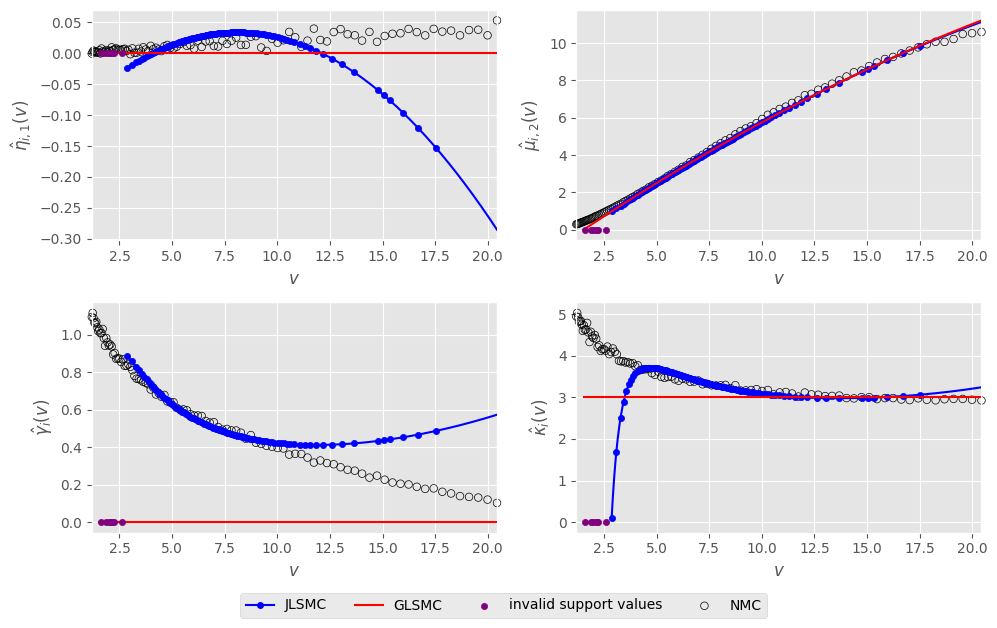

In [9]:
print(f'Number of invalid support points: {np.sum(~mask_tothat_supp_jlsmc)}')

fig, axs = plt.subplots(2, 2, figsize=(10, 6))
axs = axs.flatten()

axs[0].plot(mtm_func[mask_tothat_func_jlsmc], murawhat_func_jlsmc[mask_tothat_func_jlsmc, 0], color=color_jlsmc, zorder=3)
axs[0].scatter(mtm_supp[mask_tothat_supp_jlsmc], murawhat_supp_jlsmc[mask_tothat_supp_jlsmc, 0], color=color_jlsmc, s=20, zorder=3)
axs[0].plot(mtm_func[mask_tothat_func_glsmc], murawhat_func_glsmc[mask_tothat_func_glsmc, 0], color=color_glsmc, zorder=3)
axs[0].scatter(mtm_supp[~mask_tothat_supp_jlsmc], np.zeros_like(mtm_supp[~mask_tothat_supp_jlsmc]), color=color_invalid, s=20, zorder=3)
axs[0].scatter(mtm_test, muraw_test[:, 0], color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[0].set_xlabel('$v$')
axs[0].set_ylabel('$\\hat \\eta_{i, 1}(v)$')
axs[0].set_xlim(np.min(mtm_func), np.max(mtm_func))

axs[1].plot(mtm_func[mask_tothat_func_jlsmc], muhat_func_jlsmc[mask_tothat_func_jlsmc, 0], color=color_jlsmc, zorder=3)
axs[1].scatter(mtm_supp[mask_tothat_supp_jlsmc], muhat_supp_jlsmc[mask_tothat_supp_jlsmc, 0], color=color_jlsmc, s=20, zorder=3)
axs[1].plot(mtm_func[mask_tothat_func_glsmc], muhat_func_glsmc[mask_tothat_func_glsmc, 0], color=color_glsmc, zorder=3)
axs[1].scatter(mtm_supp[~mask_tothat_supp_jlsmc], np.zeros_like(mtm_supp[~mask_tothat_supp_jlsmc]), color=color_invalid, s=20, zorder=3)
axs[1].scatter(mtm_test, mu_test[:, 0], color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[1].set_xlabel('$v$')
axs[1].set_ylabel('$\\hat \\mu_{i, 2}(v)$')
axs[1].set_xlim(np.min(mtm_func), np.max(mtm_func))

axs[2].plot(mtm_func[mask_tothat_func_jlsmc], skewhat_func_jlsmc[mask_tothat_func_jlsmc], color=color_jlsmc, zorder=3)
axs[2].plot([None], [None], marker='o', markersize=4, color=color_jlsmc, label='JLSMC', zorder=3)
axs[2].scatter(mtm_supp[mask_tothat_supp_jlsmc], skewhat_supp_jlsmc[mask_tothat_supp_jlsmc], color=color_jlsmc, s=20, zorder=3)
axs[2].plot(mtm_func[mask_tothat_func_glsmc], skewhat_func_glsmc[mask_tothat_func_glsmc], color=color_glsmc, label='GLSMC', zorder=3)
axs[2].scatter(mtm_supp[~mask_tothat_supp_jlsmc], np.zeros_like(mtm_supp[~mask_tothat_supp_jlsmc]), color=color_invalid, s=20, label='invalid support values', zorder=3)
axs[2].scatter(mtm_test, skew_test, color='black', s=30, facecolors='none', label='NMC', clip_on=False, zorder=2)
axs[2].set_xlabel('$v$')
axs[2].set_ylabel('$\\hat \\gamma_i(v)$')
axs[2].set_xlim(np.min(mtm_func), np.max(mtm_func))
#axs[2].set_ylim(bottom=-1)

axs[3].plot(mtm_func[mask_tothat_func_jlsmc], kurthat_func_jlsmc[mask_tothat_func_jlsmc], color=color_jlsmc, zorder=3)
axs[3].scatter(mtm_supp[mask_tothat_supp_jlsmc], kurthat_supp_jlsmc[mask_tothat_supp_jlsmc], color=color_jlsmc, s=20, zorder=3)
axs[3].plot(mtm_func[mask_tothat_func_glsmc], kurthat_func_glsmc[mask_tothat_func_glsmc], color=color_glsmc, zorder=3)
axs[3].scatter(mtm_supp[~mask_tothat_supp_jlsmc], np.zeros_like(mtm_supp[~mask_tothat_supp_jlsmc]), color=color_invalid, s=20, zorder=3)
axs[3].scatter(mtm_test, kurt_test, color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[3].set_xlabel('$v$')
axs[3].set_ylabel('$\\hat \\kappa_i(v)$')
axs[3].set_xlim(np.min(mtm_func), np.max(mtm_func))

handles, labels = axs[2].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.05))
plt.tight_layout()
plt.show()

## <span id="section-3" style="color:#00B8DE"> III - Moment Matching Johnson </span>

Now, let us do the Johnson moment matching procedure based on the metrics calculated before, using the AS99 algorithm.

In [10]:
warnings.filterwarnings('ignore')

jparamshat_supp, jtypehat_supp, mask_hat_supp_jlsmc   = moment_matching_johnson(murawhat_supp_jlsmc[:, 0], muhat_supp_jlsmc[:, 0], skewhat_supp_jlsmc, kurthat_supp_jlsmc, mask_tothat_supp_jlsmc)
jparamshat_ref, jtypehat_ref, mask_hat_ref_jlsmc      = moment_matching_johnson(murawhat_ref_jlsmc[:, 0], muhat_ref_jlsmc[:, 0], skewhat_ref_jlsmc, kurthat_ref_jlsmc, mask_tothat_ref_jlsmc)

Let us identify the Johnson function (ie. Johnson distribution type) in the $(\gamma^2, \kappa)$ plane.

<Figure size 640x480 with 0 Axes>

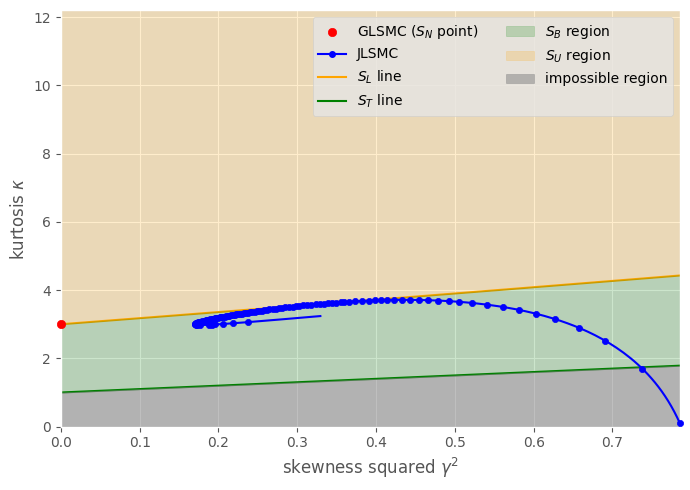

In [11]:
omega       = np.linspace(1, 1.4, 100)
beta1_sl    = (omega-1) * (omega+2)**2
kurt_sl     = omega**4 + 2*omega**3 + 3*omega**2 - 3
kurt_lim    = 1 + beta1_sl

max_kurt    = max(np.max(kurthat_func_jlsmc[mask_tothat_func_jlsmc]), np.max(kurthat_func_glsmc[mask_tothat_func_jlsmc]), np.max(kurt_sl), np.max(kurt_lim))
beta1_lim   = np.linspace(0, np.max(skewhat_func_jlsmc[mask_tothat_func_jlsmc]**2), 100)
kurt_lim2   = 1 + beta1_lim

ax.set_xlabel('skewness squared $\\gamma^2$')
ax.set_ylabel('kurtosis $\\kappa$')
ax.set_xlim(0, np.max(beta1_lim))
ax.set_ylim(0, max_kurt)
ax.legend(ncol=2)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.scatter([0], [3], color=color_glsmc, label='GLSMC ($S_N$ point)', zorder=3, clip_on=False)
ax.plot(skewhat_func_jlsmc[mask_tothat_func_jlsmc]**2, kurthat_func_jlsmc[mask_tothat_func_jlsmc], color=color_jlsmc, zorder=3, clip_on=False)
ax.scatter(skewhat_supp_jlsmc[mask_tothat_supp_jlsmc]**2, kurthat_supp_jlsmc[mask_tothat_supp_jlsmc], color=color_jlsmc, s=20, zorder=3, clip_on=False)
ax.plot([None], [None], color=color_jlsmc, marker='o', markersize=4, label='JLSMC')
ax.plot(beta1_sl, kurt_sl, color='orange', label='$S_L$ line', zorder=1)
ax.plot(beta1_sl, kurt_lim, color='green', label='$S_T$ line', zorder=1)
ax.fill_between(beta1_sl, kurt_lim, kurt_sl, color='green', alpha=0.2, label='$S_B$ region', zorder=1)
ax.fill_between(beta1_sl, kurt_sl, max_kurt*np.ones_like(kurt_sl), color='orange', alpha=0.2, label='$S_U$ region', zorder=1)
ax.fill_between(beta1_lim, kurt_lim2, np.zeros_like(kurt_lim2), color='grey', alpha=0.5, label='impossible region', zorder=1)

ax.set_xlabel('skewness squared $\\gamma^2$')
ax.set_ylabel('kurtosis $\\kappa$')
ax.set_xlim(0, np.max(beta1_lim))
ax.set_ylim(0, max_kurt)
ax.legend(ncol=2)
plt.tight_layout()
plt.show()

## <span id="section-4" style="color:#00B8DE"> IV - Value-at-Risk Function </span>

The next step is to calculate the quantiles at level $\alpha$ of the fitted Johnson distributions.

In [12]:
print(f'Number of invalid support points: {np.sum(~mask_hat_supp_jlsmc)}')

jparamshat_supp, jtypehat_supp, mtm_supp = jparamshat_supp[mask_hat_supp_jlsmc], jtypehat_supp[mask_hat_supp_jlsmc], mtm_supp[mask_hat_supp_jlsmc]
jparamshat_ref, jtypehat_ref, mtm_ref    = jparamshat_ref[mask_hat_ref_jlsmc], jtypehat_ref[mask_hat_ref_jlsmc], mtm_ref[mask_hat_ref_jlsmc]

quanthat_supp_jlsmc, mask_hat_supp_johnson  = get_quantile_johnson(jparamshat_supp, jtypehat_supp, np.array([alpha]))
mtmdiff_pdf_ref                             = np.linspace(np.min(mtmdiff_nmc_ref), np.max(mtmdiff_nmc_ref), 1000)
quanthat_ref_jlsmc, mask_hat_ref_johnson    = get_quantile_johnson(jparamshat_ref, jtypehat_ref, np.array([alpha]))
pdfhat_ref_jlsmc                            = get_pdf_johnson(jparamshat_ref, jtypehat_ref, mtmdiff_pdf_ref)
quanthat_ref_glsmc                          = get_quantile_normal(murawhat_ref_glsmc[:, 0], muhat_ref_glsmc[:, 0], alpha)
pdfhat_ref_glsmc                            = get_pdf_normal(murawhat_ref_glsmc[:, 0], muhat_ref_glsmc[:, 0], mtmdiff_pdf_ref)

Number of invalid support points: 9


In [13]:
mtm_supp            = mtm_supp[mask_hat_supp_johnson.reshape(-1)]
quanthat_supp_jlsmc = quanthat_supp_jlsmc[mask_hat_supp_johnson]

print(f'Number of invalid support points: {np.sum(~mask_hat_supp_jlsmc) + np.sum(~mask_hat_supp_johnson)}')

Number of invalid support points: 9


Notice that the fitting of Johnson distribution may have failed, or may have produced Johnson parameters outside their definition domain. We have removed the corresponding "invalid" support values.

In [14]:
varhat_func_glsmc   = get_quantile_normal(murawhat_func_glsmc[maskhat_func_glsmc[:, 0], 0], muhat_func_glsmc[maskhat_func_glsmc[:, 0], 0], alpha).reshape(-1) # VaR function estimate for GLSMC method
varhat_comp_glsmc   = get_quantile_normal(murawhat_comp_glsmc[maskhat_comp_glsmc[:, 0], 0], muhat_comp_glsmc[maskhat_comp_glsmc[:, 0], 0], alpha).reshape(-1)

var_test = portfolio.get_conditional_quantile(alpha, min(time_grid.grid[-1] - tref, mpor), tref, risk_factor_test) - mtm_test # theoretical VaR function, based on the formula

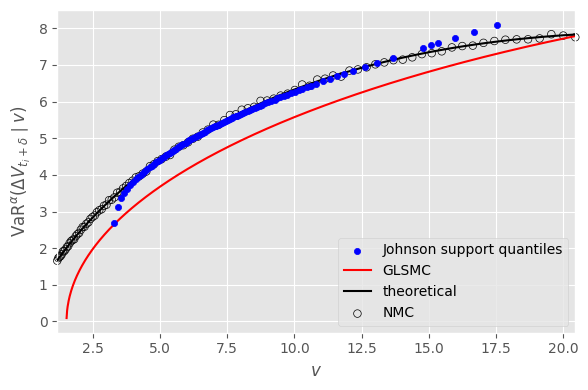

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

var_test_nmc = np.quantile(mtmdiff_nmc_test, alpha, axis=1)

ax.scatter(mtm_supp, quanthat_supp_jlsmc, color=color_jlsmc, s=20, zorder=5, clip_on=True, label='Johnson support quantiles')
ax.plot(mtm_func[maskhat_func_glsmc[:, 0]], varhat_func_glsmc, color=color_glsmc, label='GLSMC', zorder=3, clip_on=True)
ax.plot(mtm_test, var_test, color='black', label='theoretical', zorder=3, clip_on=True)
ax.scatter(mtm_test, var_test_nmc, color='black', s=30, facecolors='none', label='NMC', zorder=2, clip_on=False)
ax.set_xlabel('$v$')
ax.set_ylabel('$\\text{VaR}^\\alpha(\\Delta V_{t_i+\\delta} \\mid v)$')
ax.set_xlim(np.min(mtm_test), np.max(mtm_test))
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()

Based on the quantiles of fitted Johnson distributions associated to support values (Johnson support quantiles), we can now estimate the value-at-risk function.

In [16]:
quantile_function_setting_list = [
    {'id': 0, 'method': 'LR', 'ridge': 0, 'basis_type': 'laguerre', 'order': 2},
    {'id': 1, 'method': 'LR', 'ridge': 0, 'basis_type': 'laguerre', 'order': 3},
    {'id': 2, 'method': 'LR', 'ridge': 0, 'basis_type': 'laguerre', 'order': 4},
    {'id': 3, 'method': 'KR', 'bandwidth':'cv_ls'},
    {'id': 4, 'method': 'kNN', 'n_neighbors':1},
    {'id': 5, 'method': 'kNN', 'n_neighbors':3},
    {'id': 6, 'method': 'kNN', 'n_neighbors':5},
]
quantile_function_setting = quantile_function_setting_list[2] # choose a method among the ones proposed
quantile_func = JohnsonSupportRegressor(quantile_function_setting)
quantile_func.fit(mtm_supp, quanthat_supp_jlsmc)    
varhat_func_jlsmc = quantile_func.predict(mtm_func)
varhat_comp_jlsmc = quantile_func.predict(mtm_comp)
varhat_train_jlsmc = quantile_func.predict(mtm_train)

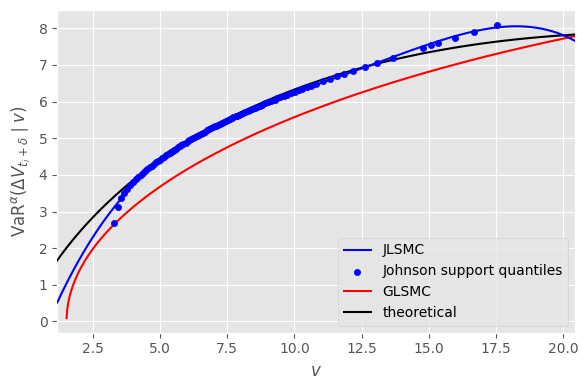

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.plot(mtm_func, varhat_func_jlsmc, color=color_jlsmc, zorder=4, clip_on=True, label='JLSMC')
ax.scatter(mtm_supp, quanthat_supp_jlsmc, color=color_jlsmc, s=20, zorder=5, clip_on=True, label='Johnson support quantiles')
ax.plot(mtm_func[maskhat_func_glsmc[:, 0]], varhat_func_glsmc, color=color_glsmc, label='GLSMC', zorder=3, clip_on=True)
ax.plot(mtm_test, var_test, color='black', label='theoretical', zorder=3, clip_on=True)
ax.set_xlabel('$v$')
ax.set_ylabel('$\\text{VaR}^\\alpha(\\Delta V_{t_i+\\delta} \\mid v)$')
ax.set_xlim(np.min(mtm_test), np.max(mtm_test))
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()

Let us compute the normalized MSE (wrt. nested MC) for both JLSMC and GLSMC methods.

In [18]:
mse_jlsmc   = np.mean((varhat_comp_jlsmc - quant_comp)**2) / np.mean((quant_comp)**2)
print(f'normalized MSE JLSMC        : {mse_jlsmc:.4f}')
mse_glsmc   = np.mean((varhat_comp_glsmc - quant_comp[maskhat_comp_glsmc[:, 0]])**2) / np.mean((maskhat_comp_glsmc[:, 0])**2)
print(f'normalized MSE GLSMC        : {mse_glsmc:.4f}')
ratio_mse   = mse_glsmc / mse_jlsmc
print(f'ratio MSE GLSMC vs JLSMC    : {ratio_mse:.4f}')

normalized MSE JLSMC        : 0.0008
normalized MSE GLSMC        : 0.5662
ratio MSE GLSMC vs JLSMC    : 750.9965


## <span id="section-5" style="color:#00B8DE"> V - Additional Statistical Verifications </span>

In this part we present severa additional statistical verifications at $t_\text{ref}$ and for a given value $X_{t_\text{ref}}$ of risk factors, ie. a given value $v$ here. More precisely, we perform statistical tests and display QQ plots to assess the hypothesis of Gaussian/Johnson distribution to the portfolio price change distribution over the MPOR, where the true (empirical) distribution is computed by a Monte-Carlo procedure. In order to highlight bias associated to the estimation of parameters, we also fit the Gaussian/Johnson distributions on the empirical distribution.

In [19]:
alpha_qq                                    = np.linspace(0.001, 0.999, 1000) # for qq plots
qq_quanthat_ref_jlsmc, mask_hat_ref_johnson = get_quantile_johnson(jparamshat_ref, jtypehat_ref, alpha_qq)
qq_quanthat_ref_glsmc                       = get_quantile_normal(murawhat_ref_glsmc[:, 0], muhat_ref_glsmc[:, 0], alpha_qq)

In [20]:
pvalad_ref      = normal_ad(mtmdiff_nmc_ref[0])[1]
pvalhat_ksn_ref = kstest(mtmdiff_nmc_ref[0], 'norm', args=(0, np.sqrt(muhat_ref_glsmc[0, 0]))).pvalue


print(f'pval AD (normal): {pvalad_ref:.4%}')
print(f'pval KS (normal): {pvalhat_ksn_ref:.4%}')

pval AD (normal): 0.0000%
pval KS (normal): 0.0000%


Let us fit a Johnson distribution to the empirical distribution using moment-matching and maximum likelihood estimation methods.

In [22]:
jparams_ref, jtype_ref, _   = backend.as99.f_johnson_M(muraw_ref[0, 0], np.sqrt(mu_ref[0, 0]), skew_ref[0], kurt_ref[0])
if jtype_ref == 'SL':
    jparams_ref_mle = lognorm.fit(mtmdiff_nmc_ref[0])
elif jtype_ref == 'SU':
    jparams_ref_mle = johnsonsu.fit(mtmdiff_nmc_ref[0])
elif (jtype_ref=='SB') or (jtype_ref=='ST'):
    jparams_ref_mle = johnsonsb.fit(mtmdiff_nmc_ref[0])
elif jtype_ref == 'SN':
    jparams_ref_mle = norm.fit(mtmdiff_nmc_ref[0])
mle_char = ''
for i in range(len(jparams_ref_mle)-1):
    mle_char += f'{jparams_ref_mle[i]:.2f}, '
mle_char += f'{jparams_ref_mle[-1]:.2f}'
print(f'Johnson params from nested MC dataset           ({jtype_ref}) : ({mle_char})') # Notice that for MLE, the parameters do not have the same interpretation as for MM because they are given by scipy functions and not AS99.
print(f'Johnson params from nested MC moments and MM    ({jtype_ref}) : ({jparams_ref[0]:.2f}, {jparams_ref[1]:.2f}, {jparams_ref[2]:.2f}, {jparams_ref[3]:.2f})')
print(f'Johnson params from regressed moments and MM    ({rev_jtypes_map[jtypehat_ref[0]]}) : ({jparamshat_ref[0, 0]:.2f}, {jparamshat_ref[0, 1]:.2f}, {jparamshat_ref[0, 2]:.2f}, {jparamshat_ref[0, 3]:.2f})')

Johnson params from nested MC dataset           (SB) : (4.20, 3.18, -7.93, 36.89)
Johnson params from nested MC moments and MM    (SB) : (5.06, 3.47, -8.38, 43.55)
Johnson params from regressed moments and MM    (SB) : (9.14, 4.49, -9.82, 83.88)


Let us now compute the p-value associated to the Kolmogorov-Smirnov test. Be careful that the p-values are usually highly biased upwards when the distribution parameters have been estimated on the same dataset that is used for the test. Thus, we use a different dataset obtained with one more Monte-Carlo procedure.

In [23]:
def pval_ks_johnson(mtm, jparams, jtype, fit_type):
    if fit_type=='MLE': # once again, for MLE, the parameters do not have the same interpretation as for MM because they are given by scipy functions and not AS99.
        if jtype == jtypes_map['SL']:
            return kstest(mtm, 'lognorm', args=jparams_ref_mle).pvalue
        elif jtype == jtypes_map['SU']:
            return kstest(mtm, 'johnsonsu', args=jparams_ref_mle).pvalue
        elif (jtype==jtypes_map['SB']) or (jtype==jtypes_map['ST']):
            return kstest(mtm, 'johnsonsb', args=jparams_ref_mle).pvalue
        elif jtype == jtypes_map['SN']:
            return kstest(mtm, 'norm', args=jparams_ref_mle).pvalue
    elif fit_type=='MM':
        gamma_, delta_, xi_, lambda_ = jparams[0], jparams[1], jparams[2], jparams[3]
        absdelta_, abslambda_ = np.abs(delta_), np.abs(lambda_)
        if jtype == jtypes_map['SL']:
            return kstest(mtm, 'lognorm', args=(1/absdelta_, xi_, lambda_*exp(-gamma_/delta_))).pvalue
        elif jtype == jtypes_map['SU']:
            return kstest(mtm, 'johnsonsu', args=(gamma_, delta_, xi_, lambda_)).pvalue
        elif (jtype==jtypes_map['SB']) or (jtype==jtypes_map['ST']):
            return kstest(mtm, 'johnsonsb', args=(gamma_, delta_, xi_, lambda_)).pvalue
        elif jtype == jtypes_map['SN']:
            return kstest(mtm, 'norm', args=((xi_-gamma_*lambda_)/delta_, abslambda_/absdelta_)).pvalue
    
pvalhat_ksj_ref     = pval_ks_johnson(mtmdiff_nmc_ref_bis[0], jparamshat_ref[0], jtypehat_ref[0], 'MM')
pval_ksj_ref        = pval_ks_johnson(mtmdiff_nmc_ref_bis[0], jparams_ref, jtypes_map[jtype_ref], 'MM')
pval_ksj_ref_mle    = pval_ks_johnson(mtmdiff_nmc_ref_bis[0], jparams_ref_mle, jtypes_map[jtype_ref], 'MLE')

print(f'pval KS from nested MC moments and MLE  ({jtype_ref}) : {(pval_ksj_ref_mle):.2%}')
print(f'pval KS from nested MC moments and MM   ({jtype_ref}) : {(pval_ksj_ref):.2%}')
print(f'pval KS from regressed moments and MM   ({rev_jtypes_map[jtypehat_ref[0]]}) : {(pvalhat_ksj_ref):.2%}')

pval KS from nested MC moments and MLE  (SB) : 84.67%
pval KS from nested MC moments and MM   (SB) : 59.61%
pval KS from regressed moments and MM   (SB) : 0.00%


Finally, we plot QQ plots and estimated distributions, first for the parameters found using regression (ie. GLSMC/JLSMC methods).

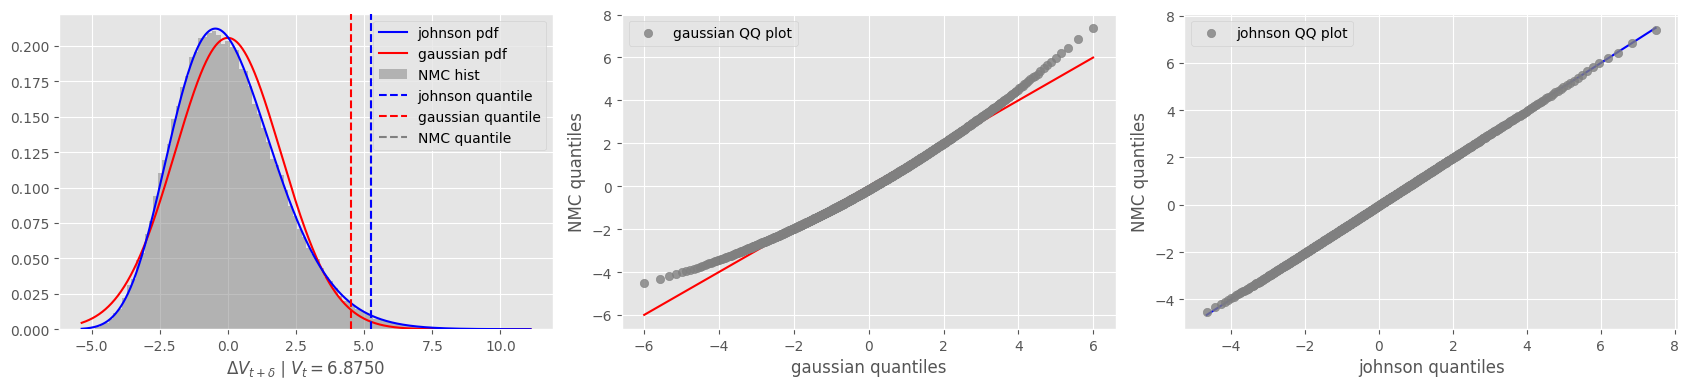

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(17, 4))

axs[0].plot(mtmdiff_pdf_ref, pdfhat_ref_jlsmc[0], color=color_jlsmc, label='johnson pdf', zorder=4, clip_on=True)
axs[0].plot(mtmdiff_pdf_ref, pdfhat_ref_glsmc[0], color=color_glsmc, label='gaussian pdf', zorder=3, clip_on=True)
axs[0].hist(mtmdiff_nmc_ref[0], bins=100, density=True, color='grey', alpha=0.5, label='NMC hist', zorder=1, clip_on=True)
#axs[0].set_ylim(top=0.1)

axs[0].axvline(x=quanthat_ref_jlsmc, color=color_jlsmc, linestyle='--', label='johnson quantile', zorder=5, clip_on=False)
axs[0].axvline(x=quanthat_ref_glsmc, color=color_glsmc, linestyle='--', label='gaussian quantile', zorder=5, clip_on=False)
axs[0].axvline(x=quant_ref, color='grey', linestyle='--', label='NMC quantile', zorder=4, clip_on=False)
axs[0].set_xlabel('$\\Delta V_{t+\\delta} \\mid V_t = $' + f'{mtm_ref[0]:.4f}')
axs[0].legend()

axs[1].plot(qq_quanthat_ref_glsmc[0], qq_quanthat_ref_glsmc[0], color=color_glsmc, zorder=3, clip_on=False)
axs[1].scatter(qq_quanthat_ref_glsmc[0], np.quantile(mtmdiff_nmc_ref[0], alpha_qq, method='inverted_cdf'), color='grey', label='gaussian QQ plot', alpha=0.8, zorder=3, clip_on=False)
axs[1].set_xlabel('gaussian quantiles')
axs[1].set_ylabel('NMC quantiles')
axs[1].legend()

axs[2].plot(qq_quanthat_ref_jlsmc[0], qq_quanthat_ref_jlsmc[0], color=color_jlsmc, zorder=3, clip_on=False)
axs[2].scatter(qq_quanthat_ref_jlsmc[0], np.quantile(mtmdiff_nmc_ref[0], alpha_qq, method='inverted_cdf'), color='grey', label='johnson QQ plot', alpha=0.8, zorder=3, clip_on=False)
axs[2].set_xlabel('johnson quantiles')
axs[2].set_ylabel('NMC quantiles')
axs[2].legend()

plt.tight_layout()
plt.show()

In order to remove the effects of parameters estimation biases due to the moments rgeression, we plot QQ plots and estimated distributions for the parameters found using empirical moments on the dataset computed by Monte-Carlo.

In [25]:
pdf_ref_johnson         = get_pdf_johnson(np.array(jparams_ref).reshape(1, -1), np.array([jtypes_map[jtype_ref]]), mtmdiff_pdf_ref)
quant_ref_johnson, _    = get_quantile_johnson(np.array(jparams_ref).reshape(1, -1),  np.array([jtypes_map[jtype_ref]]), np.array([alpha]))
pdf_ref_gaussian        = get_pdf_normal(muraw_ref[0, 0], mu_ref[0, 0], mtmdiff_pdf_ref)
quant_ref_gaussian      = get_quantile_normal(muraw_ref[0, 0], mu_ref[0, 0], alpha)
qq_quant_ref_johnson, _ = get_quantile_johnson(np.array(jparams_ref).reshape(1, -1),  np.array([jtypes_map[jtype_ref]]), alpha_qq)
qq_quant_ref_gaussian   = get_quantile_normal(muraw_ref[0, 0], mu_ref[0, 0], alpha_qq)

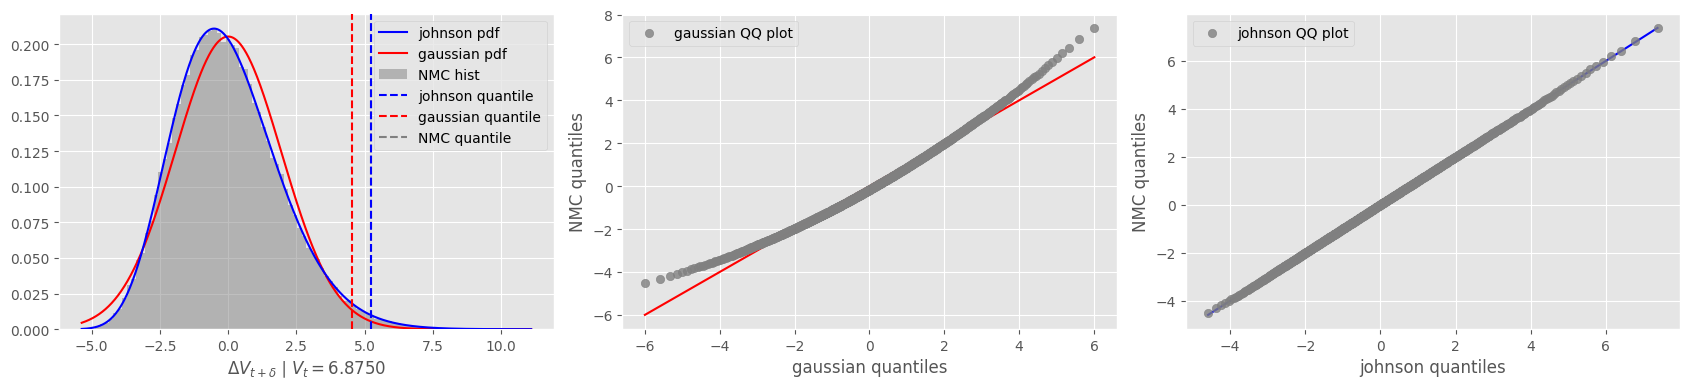

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(17, 4))

axs[0].plot(mtmdiff_pdf_ref, pdf_ref_johnson[0], color=color_jlsmc, label='johnson pdf', zorder=4, clip_on=True)
axs[0].plot(mtmdiff_pdf_ref, pdf_ref_gaussian[0], color=color_glsmc, label='gaussian pdf', zorder=3, clip_on=True)
axs[0].hist(mtmdiff_nmc_ref[0], bins=100, density=True, color='grey', alpha=0.5, label='NMC hist', zorder=1, clip_on=True)
#axs[0].set_ylim(top=0.1)

axs[0].axvline(x=quant_ref_johnson, color=color_jlsmc, linestyle='--', label='johnson quantile', zorder=5, clip_on=False)
axs[0].axvline(x=quant_ref_gaussian, color=color_glsmc, linestyle='--', label='gaussian quantile', zorder=5, clip_on=False)
axs[0].axvline(x=quant_ref, color='grey', linestyle='--', label='NMC quantile', zorder=4, clip_on=False)
axs[0].set_xlabel('$\\Delta V_{t+\\delta} \\mid V_t = $' + f'{mtm_ref[0]:.4f}')
axs[0].legend()

axs[1].plot(qq_quant_ref_gaussian[0], qq_quant_ref_gaussian[0], color=color_glsmc, zorder=3, clip_on=False)
axs[1].scatter(qq_quant_ref_gaussian[0], np.quantile(mtmdiff_nmc_ref[0], alpha_qq, method='inverted_cdf'), color='grey', label='gaussian QQ plot', alpha=0.8, zorder=3, clip_on=False)
axs[1].set_xlabel('gaussian quantiles')
axs[1].set_ylabel('NMC quantiles')
axs[1].legend()

axs[2].plot(qq_quant_ref_johnson[0], qq_quant_ref_johnson[0], color=color_jlsmc, zorder=3, clip_on=False)
axs[2].scatter(qq_quant_ref_johnson[0], np.quantile(mtmdiff_nmc_ref[0], alpha_qq, method='inverted_cdf'), color='grey', label='johnson QQ plot', alpha=0.8, zorder=3, clip_on=False)
axs[2].set_xlabel('johnson quantiles')
axs[2].set_ylabel('NMC quantiles')
axs[2].legend()

plt.tight_layout()
plt.show()

The Phitter tool enables to see which distribution may be adapted to our empirical distribution. It is useful if we want to check if other distribution hypothesis would be adapated.

In [27]:
phitter_cont = phitter.Phitter(mtmdiff_nmc_ref[0])
phitter_cont.fit()
df = phitter_cont.df_sorted_distributions_sse
df.head(5)

distribution passed       sse  \
                                          
0                 beta      ✅  0.000021   
1        chi_square_3p      ✅  0.000026   
2           johnson_sb      ✅  0.000027   
3             gamma_3p      ✅  0.000027   
4  inverse_gaussian_3p      ✅  0.000048   

                                          parameters     chi_square  \
                                                     test_statistic   
0     alpha: 11.69, beta: 149.5, A: -6.914, B: 88.43      28.844698   
1              df: 30.65, loc: -7.599, scale: 0.2481      40.681472   
2  xi: -7.93, lambda: 36.89, gamma: 4.2, delta: 3...      34.942211   
3            alpha: 15.12, loc: -7.547, beta: 0.4996      38.766644   
4              mu: 11.33, lambda: 385.3, loc: -11.32      64.856467   

                                    kolmogorov_smirnov                 \
  critical_value   p_value rejected     test_statistic critical_value   
0      31.410433  0.090863    False           0.001681       0.004293   
1      32.670573  0.006138     True           0.001849       0.004293   
2      31.410433  0.020414     True           0.002219       0.004293   
3      32.670573  0.010464     True           0.001741       0.004293   
4      32.670573  0.000002     True           0.002995       0.004293   

                     anderson_darling                                    
    p_value rejected   test_statistic critical_value   p_value rejected  
0  0.939697    False         0.231965       2.492235  0.979100    False  
1  0.883368    False         0.438720       2.492235  0.809648    False  
2  0.707374    False         0.581675       2.492235  0.665495    False  
3  0.921667    False         0.422777       2.492235  0.825876    False  
4  0.330236    False         1.417895       2.492235  0.197356    False